In [1]:
%matplotlib inline

In [2]:
from halotools.sim_manager import CachedHaloCatalog
halocat = CachedHaloCatalog(simname='bolplanck')

from halotools.utils import SampleSelector

hosts, subs = SampleSelector.host_halo_selection(table=halocat.halo_table, return_subhalos=True)

In [3]:
log10_msub_min = 11
subhalo_mpeak_cut = 10**log10_msub_min

log10_mhost_min = max(11.75, log10_msub_min)
log10_mhost_max = 14.75

subhalo_sample_mask = subs['halo_mpeak'] > subhalo_mpeak_cut
subhalo_sample_mask *= subs['halo_mvir_host_halo'] > 10**log10_mhost_min
host_halo_sample_mask = hosts['halo_mvir'] > 10**log10_mhost_min

num_mhost_bins = 25
haloprop_bins = np.logspace(log10_mhost_min, log10_mhost_max, num_mhost_bins)
log10_bin_mids = 0.5*(np.log10(haloprop_bins[:-1]) + np.log10(haloprop_bins[1:]))
bin_mids = 10**log10_bin_mids

from halotools.mock_observables import hod_from_mock

mean_occupation_bolshoi, bin_edges = hod_from_mock(subs['halo_mvir_host_halo'][subhalo_sample_mask], 
                                           hosts['halo_mvir'][host_halo_sample_mask], 
                                                   haloprop_bins)
host_halo_counts_bolshoi = np.histogram(hosts['halo_mvir'][host_halo_sample_mask], 
                                bins=haloprop_bins)[0].astype('f4')
subhalo_counts_bolshoi = np.histogram(subs['halo_mvir_host_halo'][subhalo_sample_mask], 
                                bins=haloprop_bins)[0].astype('f4')


In [4]:
from jiang_usmf import monte_carlo_subhalo_population

def mean_nsub_prediction(beta, zeta, gamma1, alpha1, gamma2, alpha2):
    params = dict(beta=beta, zeta=zeta, gamma1=gamma1, alpha1=alpha1, 
                 gamma2=gamma2, alpha2=alpha2)
    mc_nsub, mc_subhalo_mpeak = monte_carlo_subhalo_population(hosts['halo_mvir'][host_halo_sample_mask], 
                                                           log10_msub_min, 
                                                           np.log10(haloprop_bins), **params)
    mean_occupation_model, __ = hod_from_mock(np.repeat(hosts['halo_mvir'][host_halo_sample_mask], mc_nsub), 
                                           hosts['halo_mvir'][host_halo_sample_mask], haloprop_bins)
    return mean_occupation_model

def subhalo_counts_prediction(beta, zeta, gamma1, alpha1, gamma2, alpha2):
    params = dict(beta=beta, zeta=zeta, gamma1=gamma1, alpha1=alpha1, 
                 gamma2=gamma2, alpha2=alpha2)
    mc_nsub, mc_subhalo_mpeak = monte_carlo_subhalo_population(hosts['halo_mvir'][host_halo_sample_mask], 
                                                           log10_msub_min, 
                                                           np.log10(haloprop_bins), **params)
    model_subs_mhost = np.repeat(hosts['halo_mvir'][host_halo_sample_mask], mc_nsub)
    return np.histogram(model_subs_mhost, 
                                bins=haloprop_bins)[0].astype('f4') 


def chi2_mean_nsub(params):
    beta, zeta, gamma1, alpha1, gamma2, alpha2 = params
    mean_occupation_model = mean_nsub_prediction(beta, zeta, gamma1, alpha1, gamma2, alpha2)
    return np.sum((mean_occupation_model - mean_occupation_bolshoi)**2/host_halo_counts)

def chi2_subhalo_counts(params):
    beta, zeta, gamma1, alpha1, gamma2, alpha2 = params
    
    num_mocks = 10
    chi2_arr = np.zeros(num_mocks)
    for i in range(num_mocks):
        subhalo_counts_model = subhalo_counts_prediction(beta, zeta, gamma1, alpha1, gamma2, alpha2)
        chi2_arr[i] = np.sum((subhalo_counts_model - subhalo_counts_bolshoi)**2/host_halo_counts_bolshoi)
    return np.mean(chi2_arr)

    
beta_jiang14 = 5.67
zeta_jiang14 = 1.19
gamma1_jiang14 = 0.13
alpha1_jiang14 = -0.83
gamma2_jiang14 = 1.33
alpha2_jiang14 = -0.02

print(chi2_subhalo_counts((beta_jiang14, zeta_jiang14, 
              gamma1_jiang14, alpha1_jiang14, 
              gamma2_jiang14, alpha2_jiang14)))

print(chi2_subhalo_counts((beta_jiang14, zeta_jiang14, 
              gamma1_jiang14, -0.925, 
              gamma2_jiang14, alpha2_jiang14)))

599351.325
50947.9949219


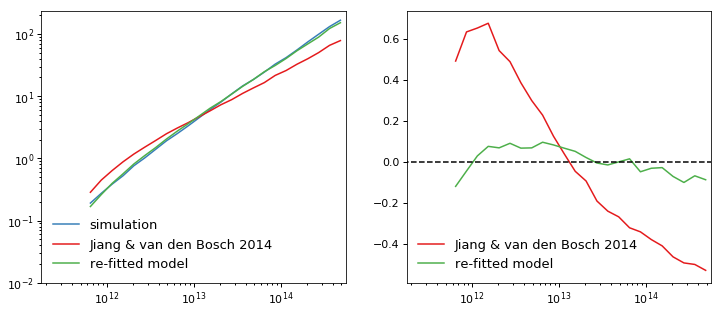

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

mean_occupation_model1 = mean_nsub_prediction(beta_jiang14, zeta_jiang14, 
                                              gamma1_jiang14, alpha1_jiang14, 
                                              gamma2_jiang14, alpha2_jiang14)

beta_jiang14 = 5.67
zeta_jiang14 = 1.19
gamma1_jiang14 = 0.13
alpha1_jiang14 = -0.83
gamma2_jiang14 = 1.33
alpha2_jiang14 = -0.02

beta_new = 4
zeta_new = zeta_jiang14
gamma1_new = gamma1_jiang14
alpha1_new = -0.925
gamma2_new = 0.25
alpha2_new = alpha2_jiang14

mean_occupation_model2 = mean_nsub_prediction(beta_new, zeta_new, 
                                              gamma1_new, alpha1_new, 
                                              gamma2_new, alpha2_new)

__=ax1.loglog()
__=ax1.plot(bin_mids, mean_occupation_bolshoi, label='simulation', color=blue)
__=ax1.plot(bin_mids, mean_occupation_model1, label='Jiang & van den Bosch 2014', color=red)
__=ax1.plot(bin_mids, mean_occupation_model2, label='re-fitted model', color=green)

xscale2 = ax2.set_xscale('log')
fracdiff1 = (mean_occupation_model1 - mean_occupation_bolshoi)/mean_occupation_bolshoi
fracdiff2 = (mean_occupation_model2 - mean_occupation_bolshoi)/mean_occupation_bolshoi

__=ax2.plot(bin_mids, fracdiff1, label='Jiang & van den Bosch 2014', color=red)
__=ax2.plot(bin_mids, fracdiff2, label='re-fitted model', color=green)
__=ax2.plot(np.logspace(log10_mhost_min-1, log10_mhost_max+1, 100), np.zeros(100), '--', color='k')

xlim2 = ax2.set_xlim(xmin=10**(log10_mhost_min-0.5), xmax=10**log10_mhost_max)
xlim1 = ax1.set_xlim(xmin=10**(log10_mhost_min-0.5), xmax=10**log10_mhost_max)
ylim1 = ax1.set_ylim(ymin=0.01)


legend1 = ax1.legend()
legend2 = ax2.legend()



In [ ]:
from scipy.optimize import minimize

beta_jiang14 = 5.67
zeta_jiang14 = 1.19
gamma1_jiang14 = 0.13
alpha1_jiang14 = -0.83
gamma2_jiang14 = 1.33
alpha2_jiang14 = -0.02

f = chi2_subhalo_counts
x0 = (beta_jiang14, zeta_jiang14, 
      gamma1_jiang14, alpha1_jiang14, gamma2_jiang14, alpha2_jiang14)

solver_methods = ['Nelder-Mead', 'COBYLA', 'Powell', 'CG', 'BFGS', 'L-BFGS-B', 'TNC']

# result = minimize(f, x0, options=dict(maxiter=10), method=solver_methods[5])

In [ ]:
# def polynomial(x, a, b, c):
#     return a + b*x + c*x**2

# def noisy_polynomial(x, a, b, c):
#     truth = polynomial(x, a, b, c)
    
#     return np.random.normal(loc=truth, scale=0.01*truth)

# a0, b0, c0 = 1, 2, 3
# a1, b1, c1 = 1.1, 2.1, 3.1

# x = np.linspace(2, 5, 100)
# correct = polynomial(x, a0, b0, c0)
# noisy_model0 = noisy_polynomial(x, a0, b0, c0)
# noisy_model1 = noisy_polynomial(x, a1, b1, c1)

# # fig, ax = plt.subplots(1, 1)

# # __=ax.plot(x, correct, color=blue)
# # __=ax.plot(x, noisy_model0, color=red)
# # __=ax.plot(x, noisy_model1, color=purple)

# def chi2(params):
#     a, b, c = params
    
#     correct = polynomial(x, a0, b0, c0)
#     model = noisy_polynomial(x, a, b, c)
#     errors = 0.1*correct
#     return np.sum(((correct - model)/errors)**2)

# f = chi2

# fracerr = 0.25
# a1 = np.random.normal(loc=a0, scale=fracerr*a0)
# b1 = np.random.normal(loc=b0, scale=fracerr*b0)
# c1 = np.random.normal(loc=c0, scale=fracerr*c0)
# x0 = (a1, b1, c1)

# solver_methods = ['Nelder-Mead', 'COBYLA', 'Powell', 'CG', 'BFGS', 'L-BFGS-B', 'TNC']
# result = minimize(f, x0, options=dict(maxiter=30000), method=solver_methods[5])

# print("x0 = {0}".format(x0))
# print("x1 = {0}".format(result.x))
